# Projeto Final 2019

**Aluno:** Franklin Alves de Oliveira

-----

Neste projeto cada aluno deve eleger um corpus de documentos de tamanho medio (pelo menos milhares de documentos). Todas as tarefas a seguir serao realizadas sobre este corpus.

-----

Então, vamos começar importando o *corpus* de *reviews* de produtos eletrônicos do site [Amazon.com](https://www.amazon.com). Esse corpus, e outros semelhantes, podem ser encontrados nesse [link](http://jmcauley.ucsd.edu/data/amazon/). 

Para esse projeto, vamos utilizar uma amostra de aproximadamente 300 mil reviews (selecionados aleatoriamente) de um total de 1.689.188 no *corpus* completo.

<br>

Antes de começarmos, vamos fazer os ***imports*** de alguns pacotes...

In [1]:
# imports
import os
import re
import nltk
import math
import string
import shutil
import gensim
import whoosh
import enchant
import logging
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# imports funcionalidades diversas
from tqdm import tqdm
from string import punctuation
from IPython.display import display, Markdown, Latex
from collections import defaultdict,Counter,OrderedDict
from sklearn.feature_extraction.text import TfidfVectorizer

# imports do nltk
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer as WPT
from nltk.stem.snowball import SnowballStemmer

**Configurações iniciais:**

In [2]:
nltk.download('stopwords')
swu = stopwords.words('english')+ list(string.punctuation)
stemmer = SnowballStemmer('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/franklin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Importando o _corpus_**:

In [3]:
# OBS: estou mantendo o índice do corpus original (completo)
df = pd.read_csv('../Amazon_electronics_reviews_sample.csv', encoding='utf-8-sig', index_col=0)
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1.0,Very Disappointed,1290643200,"11 25, 2010"
5,A2JXAZZI9PHK9Z,0594451647,"Billy G. Noland ""Bill Noland""","[3, 3]",I am using this with a Nook HD+. It works as d...,5.0,HDMI Nook adapter cable,1388707200,"01 3, 2014"
9,A3BY5KCNQZXV5U,0594451647,Matenai,"[3, 3]",This product really works great but I found th...,5.0,This works great but read the details...,1390176000,"01 20, 2014"
15,AT09WGFUM934H,0594481813,John,"[0, 0]",It does 2A and charges a DEAD Nook in a few ho...,3.0,This is the oem charger you get with the nook hd+,1377907200,"08 31, 2013"
20,A1EDI0X3GI1SK7,0972683275,AGW,"[0, 1]","Great deal, easy to mount and it appears to be...",5.0,32 In TV Mount,1323993600,"12 16, 2011"


In [4]:
corpus = df[['reviewerID', 'asin', 'reviewText']].copy()
print('Nº de observações no corpus:', corpus.shape[0])

Nº de observações no corpus: 299789


<br>

## Indexação
1. Utilizando o Whoosh indexar o seu corpus e implementar uma funçao que apresentes para os top 10 documentos da resposta a uma consulta, trechos dos documentos contendo os termos da consulta.
1. Contruir uma funçao de busca que aceite consultas frasais e facetaçao dos resultados.

In [5]:
# imports do whoosh
import whoosh.index as index
from whoosh import qparser
from whoosh import sorting
from whoosh.fields import *
from whoosh.qparser import QueryParser
from whoosh.index import create_in, open_dir

**definindo funções para criar o índice e fazer a busca**

In [6]:
def create_whoosh_id(corpus, schema):
    '''
    cria um índice no whoosh. 
    
    Argumentos:
        - corpus (list or array): lista de textos
        - schema (Schema whoosh obj): schema para criação do índice 
    '''
    # schema para criação do índice
    schema = Schema(cont=TEXT(phrase=True, stored=True))
    
    # criando índice no whoosh (armazenado na pasta ./indexdir)
    if index.exists_in('indexdir'):
        shutil.rmtree('./indexdir', ignore_errors=True) # limpa/remove o índice atual
        ix = create_in("indexdir", schema)              # cria novo índice
        writer = ix.writer()
        for text in corpus:
            writer.add_document(cont=text)
        writer.commit()
    else:
        os.mkdir('indexdir')
        ix = create_in("indexdir", schema)
        writer = ix.writer()
        for txt in corpus:
            writer.add_document(cont=txt)
        writer.commit()
    return ix

In [7]:
def search(query, corpus, schema = None, n_results=5, index= None, return_pos= False):
    '''
    Faz uma busca por palavras ou frases no corpus.
    
    Argumentos:
        - query (string): frase a ser buscada
        - corpus (array or list): lista de textos
        - n_results (int): números de resultados para exibição.
        - index (whoosh index obj.): indexador do whoosh 
        - return_pos (bool): se True, retorna uma lista com as posições onde a busca foi encontrada.
    '''
    # Se não for passado um índice, a função criará um com um schema padrão
    if index == None:
        schema = Schema(cont=TEXT(phrase=True, stored=True))
        index = create_whoosh_id(corpus, schema)
    
    # listas para armazenar os resultados
    pos=[]
    trechos=[]
    
    # faz a consulta
    query = QueryParser("cont", schema=idx.schema,group=qparser.OrGroup).parse(query)
    facets = sorting.Facets()
    facets.add_field("cont", allow_overlap=True)
    ans = index.searcher().search(query,limit=10, groupedby=facets)
    for A in ans:
        pos.append(corpus[corpus.isin([A.values()[0]])].index[0])
        trechos.append(re.split("\.\.\.", A.highlights("cont")))
    
    # exibindo os resultados  
    n_results = min(len(trechos), n_results)
    print(f'Foram encontrados \033[1m{len(trechos)}\033[0m resultados (Exibindo os \033[1m{n_results}\033[0m primeiros).')
    print(' ')
    for i in range(10):
        print(f'\033[94m\033[4mResultado {i+1} ' + f'(linha do dataframe {pos[i]}):\033[0m')
        for j in range(len(trechos[i])):
            display(Markdown(f'- {j+1}:  ...  '+trechos[i][j]+'  ...'))
        print('')
        
    if return_pos:
        return pos

In [ ]:
# criando um índice com o whoosh
# schema = Schema(cont=TEXT(phrase=True, stored=True))
# idx = create_whoosh_id(corpus['reviewText'], schema)  

# se o índice já foi criado, executar a linha abaixo
idx = index.open_dir("indexdir")

In [17]:
# exibe resultados do mais para o menos similar
search('really works', corpus['reviewText'], index=idx, n_results=10)

Foram encontrados 2927 resultados (Exibindo os 10 primeiros).
 
Resultado 1 (linha do dataframe 38238):


- 1:  ...  Bought but I never <b class="match term0">really</b> used it, but <b class="match term1">works</b> when I need it to  ...


Resultado 2 (linha do dataframe 33186):


- 1:  ...  it is still be used. <b class="match term1">works</b> good for my phones  ...

- 2:  ...  of this cable is <b class="match term0">really</b> good, cant beat it  ...

- 3:  ...  like i said still <b class="match term1">works</b> good  ...


Resultado 3 (linha do dataframe 40310):


- 1:  ...  I dont <b class="match term0">really</b> know what to say in  ...

- 2:  ...  for this item. It <b class="match term1">works</b>, it <b class="match term1">works</b> well, it <b class="match term1">works</b> exactly as described  ...


Resultado 4 (linha do dataframe 3048):


- 1:  ...  It just <b class="match term1">works</b>, it's <b class="match term0">really</b> trouble-proof. I have  ...


Resultado 5 (linha do dataframe 31374):


- 1:  ...  This one <b class="match term0">really</b> <b class="match term1">works</b>.  And it has a nice gold  ...


Resultado 6 (linha do dataframe 35644):


- 1:  ...  simple plug I can't <b class="match term0">really</b> say that it changes  ...

- 2:  ...  my world it just <b class="match term1">works</b> the way it's intended  ...


Resultado 7 (linha do dataframe 15567):


- 1:  ...  UV protection is not <b class="match term0">really</b> even the reason I  ...

- 2:  ...  of the lens, and it <b class="match term1">works</b> perfectly for that  ...


Resultado 8 (linha do dataframe 32750):


- 1:  ...  There <b class="match term0">really</b> isn't much to say about  ...

- 2:  ...  a basic cable. It <b class="match term1">works</b> as expected and it  ...


Resultado 9 (linha do dataframe 11338):


- 1:  ...  <b class="match term1">works</b> <b class="match term0">really</b> well when taking  ...


Resultado 10 (linha do dataframe 22333):


- 1:  ...  <b class="match term2">Really</b> enjoy this product use it with my professional  ...

- 2:  ...  dragon all the time. <b class="match term3">Works</b> well!The price was  ...

<br>

## Modelagem de Assuntos
1. Usando a biblioteca Gensim, treine um modelo LSI e LDA para o seu corpus propondo uma metodologia para otimizaçao do número de assuntos
2. Construa uma matriz de similaridade entre os documentos do corpus a partir dos pesos 

<font color='blue'>**Links interessantes:**</font>

> - **LSI (Latent Semantic Indexing) or LSA (Latent semantic analysis):** [Wikipedia](https://en.wikipedia.org/wiki/Latent_semantic_analysis)
<br>
>
> - **LDA (Latent Dirichlet Allocation):** [Wikipedia](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation)

<br>

## item 1

In [6]:
# imports adicionais do gensim
from gensim.utils import simple_preprocess
from gensim import corpora, models, similarities
from gensim.models import CoherenceModel, wrappers

### Pré-processamento do texto

<font color='red'>**Obs:** verifiquei que os resultados ficaram melhores sem remover stopwords e sem "stemizar" o texto - ao fazer isso, apareciam algumas inconsistências como letras soltas e 'sony' se tornava 'son', que têm significados bem distintos </font>

In [7]:
def tokenize_and_remove_sw(text,sw,remove_sw=True, stemize=True):
    '''
    Tokeniza o texto e remove stopwords.
    
    Argumentos:
        - text (string): texto.
        - sw (list): lista de stopwords.
        - remove_sw (bool): se True, remove stopwords.
        - stemize (bool): se True, aplica stemmer ao texto.
    '''
    if remove_sw and stemize:
        clean_text = [stemmer.stem(token.strip(punctuation).lower()) for token in 
                                                   WPT().tokenize(text) if token not in sw]
    elif remove_sw:
        clean_text = [token.strip(punctuation).lower() for token in 
                                                   WPT().tokenize(text) if token not in sw]
    elif stemize:
        clean_text = [stemmer.stem(token.strip(punctuation).lower()) for token in 
                                                   WPT().tokenize(text)]
    else:
        clean_text = [token.strip(punctuation).lower() for token in 
                                                   WPT().tokenize(text)]
    return clean_text

In [11]:
def train_models(texts, min_count=1, model=None, n_topics=8):
    counter = Counter([])
    for text in texts:
        counter.update(text)
    # retorna mensagem de erro se nenhum modelo é especificado
    if model == None:
        return 'Error: Please pass value to model argument from ["tf-idf", "lsi", "lda"]'
    
    # lista de modelos a serem estimados
    model = list(model)
    
    # mantém apenas tokens que aparecem ao menos duas vezes
    list_of_texts = [[token for token in text if counter[token] > min_count] 
                                                 for text in texts]  
    # criando dicionário:
    dic = corpora.Dictionary(list_of_texts)
    dic.save('vocab_W2V.dict')
    
    # criando listas de frequências:
    frequency_lists = [dic.doc2bow(token) for token in list_of_texts]
    corpora.MmCorpus.serialize('frequency_list.mm', frequency_lists)
    
    res = []  # lista para armazenar os resultados
    #tf-idf:
    if sum(['idf' in s for s in model]) > 0:
        tfidf = models.TfidfModel(frequency_lists)
        tfidf.save('TF_IDF_model.mm')
        corpus_tfidf = tfidf[frequency_lists]
        res.extend([tfidf, corpus_tfidf])
    
    if len(res) == 0:
        return 'Oops. To compute LSI and/or LDA models is necessary to include TF-IDF.'
    
    #LSI:
    if sum(['lsi' in s for s in model]) > 0:
        mod_lsi = models.LsiModel(corpus_tfidf, id2word= dic, num_topics=n_topics)
        mod_lsi.save('LSI_model.mm')
        corpus_lsi = mod_lsi[corpus_tfidf]
        res.extend([mod_lsi, corpus_lsi])
        
    #LDA:
    if sum(['lda' in s for s in model]) > 0:
        mod_lda = models.LdaModel(corpus_tfidf, id2word= dic, num_topics=n_topics)
        mod_llda.save('LDA_model.mm')
        corpus_lda = mod_lda[corpus_tfidf] 
        res.extend([mod_lda, corpus_lda])

    return tuple(res)



def compute_lda_metrics(lda_model, min_count= 1,texts=None):  
    counter = Counter([])
    for text in texts:
        counter.update(text)

    # mantém apenas tokens que aparecem ao menos duas vezes
    list_of_texts = [[token for token in text if counter[token] > min_count] 
                                                 for text in texts]
    # criando dicionário:
    dic = corpora.Dictionary(list_of_texts)
    
    # criando listas de frequências:
    frequency_lists = [dic.doc2bow(token) for token in list_of_texts]
    
    # Compute Perplexity
    perplexity = lda_model.log_perplexity(frequency_lists)
#     print('Perplexity:', perplexity)
    
    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts= list_of_texts, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
#     print('\nCoherence Score: ', coherence_lda)
    
    return (perplexity, coherence_lda)

<font color='red' size='5'>**OBS:** Para recuperar as informações, carregar a lista de frequências, tf-idf e os modelos. Depois, serializar dessa forma: corpus_lda = mod_lda[corpus_tfidf], onde corpus_tfidf = tfidf[frequency_lists] </font>

### stemizando e removendo stopwords

In [9]:
n = corpus.shape[0]  # número de obs
corpus['tokenized_reviews'] = corpus['reviewText'].iloc[:n].apply(lambda x:
                            tokenize_and_remove_sw(x, swu, stemize=False, remove_sw=True))

### Selecionando o número de tópicos

Agora, vamos treinar o modelo **LDA** para diferentes números de tópicos e selecionar a quantidade que maximiza o score de coerência.

In [25]:
perplexity = []
coherence = []
num_topics = []

# n = 10000  # número de observações
for k in tqdm(range(1,20)):
    # treinando os modelos
    tfidf_model, tfidf, lsi_model, lsi, lda_model, lda = train_models(corpus['tokenized_reviews'].iloc[:n], 
                                                        model=['tf-idf', 'lsi', 'lda'], n_topics=k)
    
    metrics = compute_lda_metrics(lda_model, texts=corpus['tokenized_reviews'].iloc[:n])
    perplexity.append(metrics[0])
    coherence.append(metrics[1])
    num_topics.append(n)

100%|██████████| 19/19 [10:34<00:00, 33.41s/it]


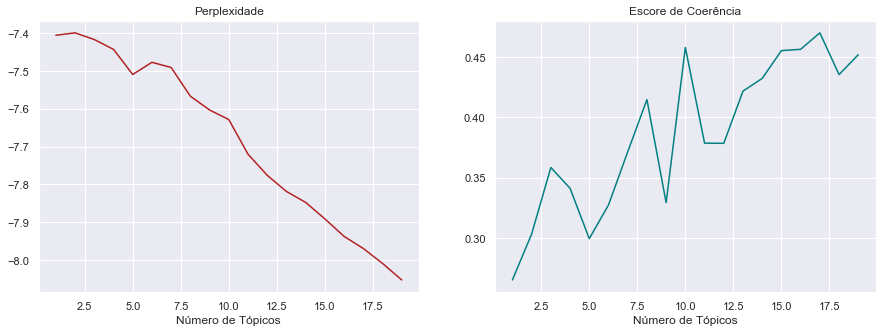

In [26]:
sns.set()
fig, ax = plt.subplots(ncols=2, figsize=(15,5));

ax[0].plot(num_topics, perplexity, color='firebrick');
ax[1].plot(num_topics, coherence, color='teal');

ax[0].set_xlabel('Número de Tópicos');
ax[1].set_xlabel('Número de Tópicos');

ax[0].set_title('Perplexidade');
ax[1].set_title('Escore de Coerência');

Analisando os gráficos acima, temos que a quantidade de tópicos que maximiza o escore de coerência e minimiza a métrica de perplexidade é $18$. Agora, vamos computar os modelos para essa quantidade de tópicos.

In [10]:
# obtendo resultados dos três modelos
tfidf_model, tfidf, lsi_model, lsi, lda_model, lda = train_models(corpus['tokenized_reviews'].iloc[:n], 
                                                            model=['tf-idf', 'lsi', 'lda'], n_topics=18)

KeyboardInterrupt: 

#### TF-IDF

Abaixo, temos um exemplo de tf-idf para o primeiro *review* do corpus. (id_termo, frequência)

In [28]:
corpus.iloc[0,1]

'0528881469'

In [29]:
# exemplo: tf-idf para o primeiro texto
sorted(tfidf[0], key=lambda tupla: tupla[1],reverse=True)[:10]

[(143, 0.41190681660828277),
 (147, 0.4067202644046221),
 (9, 0.2569114325863382),
 (104, 0.24062103096605883),
 (118, 0.2335106169280995),
 (34, 0.16476272664331312),
 (55, 0.15236309592155756),
 (134, 0.1517527242527527),
 (135, 0.14560168593230155),
 (10, 0.14510977692654053)]

#### LSI

In [30]:
sorted(lsi[0], key=lambda tupla:tupla[1], reverse=True)

[(0, 0.1388798897967015),
 (16, 0.05944610675675745),
 (17, 0.04202774135535914),
 (7, 0.03421543615986791),
 (1, 0.029065377920136696),
 (6, 0.029047627452630245),
 (11, 0.02848793612122293),
 (10, 0.025470027122018138),
 (9, 0.01727273258515659),
 (5, 0.009408559438690033),
 (8, 0.006754410773540017),
 (13, 0.004510186008428679),
 (12, 0.0006103133998796594),
 (15, -0.01473085783145636),
 (4, -0.023472803856375277),
 (14, -0.029626336130132724),
 (2, -0.03784302103477646),
 (3, -0.052598389917270776)]

In [31]:
lsi_model.print_topics(num_topics=5, num_words=6)

[(0,
  '0.191*"len" + 0.159*"i" + 0.156*"" + 0.137*"camera" + 0.133*"cabl" + 0.125*"use"'),
 (1,
  '-0.658*"len" + -0.206*"camera" + 0.188*"cabl" + 0.158*"sound" + -0.142*"filter" + 0.142*"headphon"'),
 (2,
  '0.373*"headphon" + 0.353*"sound" + -0.305*"cabl" + 0.219*"ear" + 0.203*"speaker" + -0.159*"router"'),
 (3,
  '0.590*"cabl" + -0.334*"camera" + 0.286*"len" + -0.166*"batteri" + -0.163*"card" + -0.151*"mous"'),
 (4,
  '0.505*"camera" + 0.377*"cabl" + -0.318*"mous" + -0.237*"len" + -0.190*"router" + 0.152*"pictur"')]

O tópico 3 parece estar associado à equipamentos de fotografia, pois aparecem as palavras **camera**, **cable**, **batteries**, **lens** e **card**.

Já o tópico 2, parece estar associado à equipamentos de som, pois aparecem as palavras **headphone**, **sound**, **cable**, **ear** e **speaker**.

#### LDA

In [32]:
lda[0]

[(5, 0.063259326), (7, 0.71208805), (10, 0.121258)]

In [33]:
sorted(lda_model.print_topics(num_topics=5, num_words=6))

[(2,
  '0.014*"surg" + 0.013*"outlet" + 0.009*"protector" + 0.007*"plug" + 0.007*"cabl" + 0.005*"work"'),
 (9,
  '0.005*"gaug" + 0.004*"dash" + 0.004*"soft" + 0.004*"16" + 0.004*"depth" + 0.004*"mb"'),
 (11,
  '0.008*"scanner" + 0.007*"word" + 0.006*"didnt" + 0.005*"awar" + 0.005*"fi" + 0.005*"booster"'),
 (15,
  '0.011*"mous" + 0.006*"cabl" + 0.005*"prime" + 0.005*"doe" + 0.004*"use" + 0.004*"product"'),
 (16,
  '0.017*"router" + 0.012*"port" + 0.010*"linksi" + 0.010*"wireless" + 0.010*"usb" + 0.009*"network"')]

O tópico 4 parece estar associado a periféricos para computadores, pois aparecem as palavras **cds**, **mouse**, **cordless**.

## item 2

### Construindo matriz de similaridades.

In [34]:
def create_similarity_matrix(model, n=10):
    '''
    Cria matriz de similaridade.
    
    Argumentos:
        - model (gensim model obj.): um dos três modelos (tf-idf, LSI ou LDA)
        - n_doc (int): # de documentos para calcular as similaridades (dimensão da matriz)
    '''
    head = corpus.iloc[:n,].index  # estou usando índice do dataframe para identificação
    source = [elem[:n] for elem in list(similarities.MatrixSimilarity(model))][:n]

    similarity_matrix = pd.DataFrame(source, index= head.values, columns= head)
    return similarity_matrix

In [35]:
create_similarity_matrix(tfidf, 100)

,1,5,9,15,20,22,24,43,54,57,...,419,423,432,438,439,440,441,454,469,472
1,1.000000,0.005948,0.026756,0.014622,0.004945,0.015805,0.031805,0.019847,0.000000,0.024251,...,0.034498,0.058410,0.058394,0.032098,0.037979,0.012416,0.005872,0.076585,0.044781,0.028913
5,0.005948,1.000000,0.194203,0.147098,0.057803,0.004549,0.059297,0.060673,0.066198,0.036849,...,0.004289,0.012172,0.144384,0.028593,0.075381,0.007148,0.003637,0.045040,0.167440,0.124308
9,0.026756,0.194203,1.000000,0.153678,0.064982,0.046493,0.048990,0.048882,0.052160,0.040463,...,0.046026,0.040324,0.218313,0.050439,0.118876,0.026396,0.002549,0.080650,0.263554,0.208994
15,0.014622,0.147098,0.153678,1.000000,0.000355,0.028550,0.025346,0.017913,0.025990,0.021017,...,0.024636,0.017173,0.116424,0.020743,0.063388,0.019722,0.045292,0.037741,0.144687,0.098966
20,0.004945,0.057803,0.064982,0.000355,1.000000,0.182559,0.221209,0.133285,0.086857,0.277370,...,0.023124,0.009135,0.006128,0.011759,0.016330,0.000000,0.000000,0.019745,0.023392,0.010394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,0.012416,0.007148,0.026396,0.019722,0.000000,0.007592,0.006300,0.004331,0.000000,0.014491,...,0.002009,0.015712,0.001622,0.001371,0.015922,1.000000,0.000000,0.013427,0.006217,0.024509
441,0.005872,0.003637,0.002549,0.045292,0.000000,0.000000,0.000000,0.012412,0.000000,0.007455,...,0.070495,0.035131,0.048795,0.052978,0.001072,0.000000,1.000000,0.001605,0.099516,0.102101
454,0.076585,0.045040,0.080650,0.037741,0.019745,0.012486,0.021699,0.011469,0.051163,0.054860,...,0.078416,0.206551,0.227930,0.137126,0.101444,0.013427,0.001605,1.000000,0.181401,0.267697
469,0.044781,0.167440,0.263554,0.144687,0.023392,0.016270,0.006732,0.024711,0.011894,0.023897,...,0.136695,0.072316,0.289288,0.244515,0.174925,0.006217,0.099516,0.181401,1.000000,0.308044


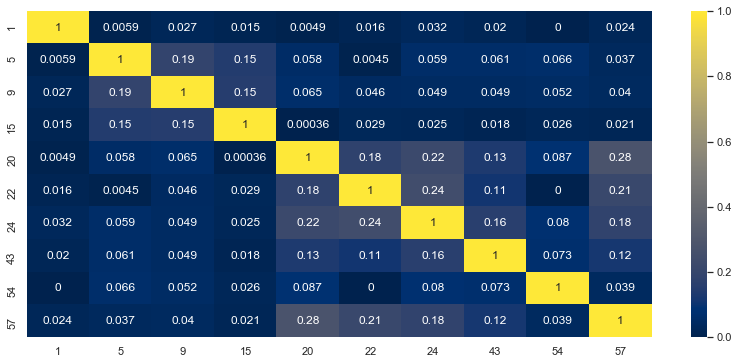

In [36]:
plt.figure(figsize=(14,6))
sns.heatmap(create_similarity_matrix(tfidf, 10), cmap='cividis', annot=True)

# corrigindo "bug" do seaborn (cortando pela metade a primeira e última linha)
b, t = plt.ylim() # limites de y
b += 0.5 # lim. inferior + 0.5
t -= 0.5 # lim. superior - 0.5
plt.ylim(b, t) # atualiza ylim
plt.show()

<br>

## Word2vec
1. Ainda usando a biblioteca Gensim, Construa uma representaçao vetorial semantica(word2vec) do seu corpus de escolha. Podem seguir este [tutorial](https://rare-technologies.com/word2vec-tutorial/)
2. Construa uma representaçao simila usando [FastText](https://radimrehurek.com/gensim/models/fasttext.html#gensim.models.fasttext.FastText). Veja este [Tutorial](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/FastText_Tutorial.ipynb)

### **Configurações iniciais**

In [135]:
### Executar a linha abaixo se quiser visualizar um logging da execução do modelo
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

### **Pré-processando o texto (tokenizando e removendo stopwords)**

<font color='red'>**Obs:** verifiquei que os resultados ficaram melhores sem remover stopwords e sem "stemizar" o texto - ao fazer isso, apareciam algumas inconsistências como letras soltas e 'sony' se tornava 'son', que têm significados bem distintos </font>

In [57]:
n = 50000  # número de observações
corpus['tokenized_rewiews'] = corpus['reviewText'].iloc[:n].apply(lambda x:
                            tokenize_and_remove_sw(x, swu, stemize=True, remove_sw=True))

### Treinando modelo Word2Vec

In [38]:
def train_W2V(list_tokenized_texts, min_count=1, workers=2, n_epochs= 5):
    '''
    Treina o modelo Word2Vec e retorna o objeto gensim.models.Word2Vec. 
    
    Cria os seguintes arquivos na pasta local:
        - vocab_W2V.dict: vocabulário
        - corpusWikiW2V.mm: lista de frequências 
        - w2v_mode.sav: modelo Word2Vec (gensim)
        
    Argumentos:
        - list_tokenized_texts (list): lista de textos tokenizados
        - min_count (int): frequência mínima para contar tokens
        - workers (int): número de threads para treinar o modelo W2V.
        - n_epochs (int): número de épocas para treinar o modelo.
    '''
    counter = Counter([])
    for text in list_tokenized_texts:
        counter.update(text)
        
    # mantém apenas tokens que aparecem ao menos duas vezes
    list_of_texts = [[token for token in text if counter[token] > min_count] 
                                                 for text in list_tokenized_texts]
    
    # criando dicionário:
    dic = corpora.Dictionary(list_of_texts)
    dic.save('vocab_W2V.dict')
    
    # criando listas de frequências:
    frequency_lists = [dic.doc2bow(token) for token in list_of_texts]
    corpora.MmCorpus.serialize('frequency_list.mm', frequency_lists)
    
    # treinando W2V:
    mod_w2v = models.Word2Vec(list_of_texts, min_count=min_count, workers=workers, iter= n_epochs)
    mod_w2v.save('w2v_model.sav')
    
    return mod_w2v

In [58]:
n = 50000  # número de observações
w2v = train_W2V(list(corpus['tokenized_rewiews'].iloc[:n]), n_epochs=10, workers=6)
# model = gensim.models.Word2Vec.load('w2v_model.sav')
print(w2v)

Word2Vec(vocab=22116, size=100, alpha=0.025)


In [59]:
w2v.wv.most_similar(positive='son')  # tem impurezas no corpus (números e letras soltos)

[('daughter', 0.868731677532196),
 ('dad', 0.8374792337417603),
 ('husband', 0.8309828042984009),
 ('mom', 0.8110055923461914),
 ('girlfriend', 0.7916345596313477),
 ('boyfriend', 0.7752252817153931),
 ('wife', 0.7715990543365479),
 ('sister', 0.7710281610488892),
 ('father', 0.7672308683395386),
 ('birthday', 0.7631523013114929)]

In [60]:
w2v.wv.most_similar(positive=stemmer.stem('sony'))  # tem impurezas no corpus (números e letras soltos)

[('panason', 0.7534866333007812),
 ('philip', 0.6960077881813049),
 ('jvc', 0.6459434032440186),
 ('dcr', 0.6130777597427368),
 ('v700', 0.5964751243591309),
 ('dvp', 0.5831491351127625),
 ('kdl', 0.5788460969924927),
 ('mdr', 0.5652310848236084),
 ('dsc', 0.5629104971885681),
 ('ht21', 0.5582513213157654)]

In [61]:
w2v.wv.most_similar(positive=stemmer.stem('camera'))  

[('slr', 0.7478739023208618),
 ('dslr', 0.6720173358917236),
 ('slrs', 0.6716471910476685),
 ('canon', 0.6654139161109924),
 ('rebel', 0.6491202712059021),
 ('kodak', 0.6258758902549744),
 ('tripod', 0.6158342361450195),
 ('nikon', 0.6143075227737427),
 ('digicam', 0.6138743162155151),
 ('d40', 0.6117902994155884)]

In [62]:
w2v.wv.most_similar(positive=stemmer.stem('linux'))  

[('ubuntu', 0.8315101861953735),
 ('xp', 0.7919223308563232),
 ('vista', 0.789918065071106),
 ('winxp', 0.7728351354598999),
 ('osx', 0.7540910243988037),
 ('sp2', 0.7529343366622925),
 ('win7', 0.741349458694458),
 ('win98', 0.7406677007675171),
 ('64bit', 0.7330875992774963),
 ('sp3', 0.7328019142150879)]

In [63]:
w2v.wv.n_similarity(['linux'], ['ubuntu'])

0.83151007

In [64]:
w2v.wv.closer_than(stemmer.stem('white'), stemmer.stem('black'))

['gray', 'grey', 'tint']

In [65]:
w2v.wv.closer_than(stemmer.stem('man'), stemmer.stem('woman'))

['guy',
 'he',
 'babi',
 'she',
 'yeah',
 'boy',
 'hey',
 'lol',
 'heck',
 'dog',
 'god',
 'gonna',
 'hell',
 'somebodi',
 'scream',
 'young',
 'girl',
 'freak',
 'junki',
 'laugh',
 'ladi',
 'teenag',
 'omg',
 'forbid']

### Construindo uma representação similar com FastText

In [50]:
def train_FastText(list_tokenized_texts, min_count=1, workers=2, n_epochs= 5):
    '''
    Treina o modelo Word2Vec e retorna o objeto gensim.models.Word2Vec. 
    
    Cria os seguintes arquivos na pasta local:
        - vocab_W2V.dict: vocabulário
        - corpusWikiW2V.mm: lista de frequências 
        - w2v_mode.sav: modelo Word2Vec (gensim)
        
    Argumentos:
        - list_tokenized_texts (list): lista de textos tokenizados
        - min_count (int): frequência mínima para contar tokens
        - workers (int): número de threads para treinar o modelo W2V.
        - n_epochs (int): número de épocas para treinar o modelo.
    '''
    counter = Counter([])
    for text in list_tokenized_texts:
        counter.update(text)
        
    # mantém apenas tokens que aparecem ao menos duas vezes
    list_of_texts = [[token for token in text if counter[token] > min_count] 
                                                 for text in list_tokenized_texts]
    
    # criando dicionário:
    dic = corpora.Dictionary(list_of_texts)
    dic.save('vocab_W2V.dict')
    
    # criando listas de frequências:
    frequency_lists = [dic.doc2bow(token) for token in list_of_texts]
    corpora.MmCorpus.serialize('frequency_list.mm', frequency_lists)
    
    # treinando W2V:
    mod_fast_txt = models.FastText(list_of_texts, min_count=min_count, workers=workers, iter= n_epochs)
    mod_fast_txt.save('fast_txt_model.sav')
    
    return mod_fast_txt

In [51]:
n = 50000  # número de observações
ft = train_W2V(list(corpus['tokenized_rewiews'].iloc[:n]), n_epochs=10, workers=6)
# model = gensim.models.Word2Vec.load('w2v_model.sav')
print(ft)

Word2Vec(vocab=13573, size=100, alpha=0.025)


In [53]:
w2v.wv.most_similar(positive=stemmer.stem('linux'))  

[('winxp', 0.8606674671173096),
 ('vista', 0.8587571382522583),
 ('xp', 0.8580197691917419),
 ('win', 0.8336136937141418),
 ('sp2', 0.8272488713264465),
 ('98', 0.8215510845184326),
 ('win98', 0.821488082408905),
 ('win2k', 0.7998870015144348),
 ('gateway', 0.7890381813049316),
 ('mac', 0.7884417772293091)]

In [54]:
w2v.wv.closer_than(stemmer.stem('white'), stemmer.stem('black'))

[]

In [52]:
ft.wv.n_similarity(['linux'], ['ubuntu'])

0.7915061

**Fim!**